In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2, os
import random
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical, plot_model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, regularizers, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
Altered_data =  np.load('/content/drive/MyDrive/DL_project/Final_Altered.npy',allow_pickle=True)
Real_data =  np.load('/content/drive/MyDrive/DL_project/Final_Real.npy',allow_pickle=True)

In [ ]:
np.shape(Real_data)

(6000, 5)

In [4]:
img_size = 96
X_Altered,y_Altered=[],[]
# sample data [ID,G, fingerNum, img_resize, "Real/Fake"]

for ID,_, fingerNum, feature,_ in Altered_data:
    if ID in range(0,400):
        X_Altered.append(feature)
        y_Altered.append(fingerNum)

#del Altered_data

In [5]:
X_Altered = np.array(X_Altered).reshape(-1, img_size, img_size, 1)
X_Altered = X_Altered /255.0 # Normalize to [0, 1]

In [6]:
y_Altered = to_categorical(y_Altered, num_classes=10)  # 10 fingers per person

In [7]:
X_fingerNum_train, X_fingerNum_val, y_fingerNum_train, y_fingerNum_val = train_test_split(
    X_Altered, y_Altered, test_size=0.2, random_state=2)

In [8]:
X_test, y_test = [], []
for ID,_, fingerNum, feature,_ in Real_data:
    if ID in range(400,600):
        X_test.append(feature)
        y_test.append(fingerNum)

In [9]:
X_test = np.array(X_test).reshape(-1, img_size, img_size, 1)
X_test = X_test / 255.0

In [10]:
y_test = to_categorical(y_test, num_classes=10)

In [11]:
print("Shapes:                  Feature shape    label shape")
print("----------------------------------------------------")
print("fingerNum_Train:      ", np.shape(X_fingerNum_train), np.shape(y_fingerNum_train))
print("fingerNum_Validation: ", np.shape(X_fingerNum_val), np.shape(y_fingerNum_val))
print("fingerNum_Test:       ", np.shape(X_test), np.shape(y_test))

del Altered_data, Real_data,X_Altered, y_Altered # Free some memory again

Shapes:                  Feature shape    label shape
----------------------------------------------------
fingerNum_Train:       (26249, 96, 96, 1) (26249, 10)
fingerNum_Validation:  (6563, 96, 96, 1) (6563, 10)
fingerNum_Test:        (2000, 96, 96, 1) (2000, 10)


In [38]:
nets = 1
model = [0] * nets
final_Dense_units = [10]
model_name = ['FingerNum_Mod']
for i in range(nets):
    model[i] = Sequential(name=model_name[i])

    model[i].add(layers.Conv2D(32, (5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape = (96, 96, 1)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Conv2D(64,(5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Conv2D(128,(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Dropout(0.3))
    model[i].add(layers.Flatten())
    model[i].add(layers.Dense(256, activation='relu'))
    model[i].add(layers.Dropout(0.4))
    model[i].add(layers.Dense(final_Dense_units[i], activation='softmax'))

    # Complete with Adam optimizer and entropy cost
    model[i].compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
    model[i].summary()

Model: "FingerNum_Mod"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 92, 92, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 92, 92, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 64)        51264     
                                                                 
 batch_normalization_1 (Batc  (None, 42, 42, 64)       256       
 hNormalization)                                                 
                                                     

In [39]:
history = [0] * nets
CallBack = [0] * nets
ReduceLR_minlr = [1e-9, 1e-7]
epochs = 30
batch_size = 64
for i in range(nets):
    CallBack[i] = [
        callbacks.EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1),
        callbacks.ReduceLROnPlateau(factor=0.1, patience=1, min_lr=ReduceLR_minlr[i], verbose=1),
        callbacks.TensorBoard(log_dir="./log_dir/"+model_name[i])]

In [40]:
history[0] = model[0].fit(X_fingerNum_train, y_fingerNum_train,
                    batch_size = batch_size,
                    epochs = epochs, 
                    validation_data = (X_fingerNum_val, y_fingerNum_val),
                    verbose = 1, callbacks= CallBack[0])

Epoch 1/30
411/411 [==============================] - 26s 59ms/step - loss: 1.8658 - accuracy: 0.4023 - val_loss: 3.0923 - val_accuracy: 0.2421 - lr: 1.0000e-04
Epoch 2/30
411/411 [==============================] - 24s 58ms/step - loss: 1.2306 - accuracy: 0.6075 - val_loss: 0.9601 - val_accuracy: 0.7189 - lr: 1.0000e-04
Epoch 3/30
411/411 [==============================] - 24s 57ms/step - loss: 0.9104 - accuracy: 0.7202 - val_loss: 0.6944 - val_accuracy: 0.8237 - lr: 1.0000e-04
Epoch 4/30
411/411 [==============================] - 22s 53ms/step - loss: 0.6705 - accuracy: 0.8078 - val_loss: 0.4715 - val_accuracy: 0.8938 - lr: 1.0000e-04
Epoch 5/30
411/411 [==============================] - 23s 56ms/step - loss: 0.4860 - accuracy: 0.8745 - val_loss: 0.3943 - val_accuracy: 0.9200 - lr: 1.0000e-04
Epoch 6/30
411/411 [==============================] - 23s 57ms/step - loss: 0.3698 - accuracy: 0.9157 - val_loss: 0.2817 - val_accuracy: 0.9584 - lr: 1.0000e-04
Epoch 7/30
411/411 [==============

Finger recognition accuracy:  60.350000858306885 %


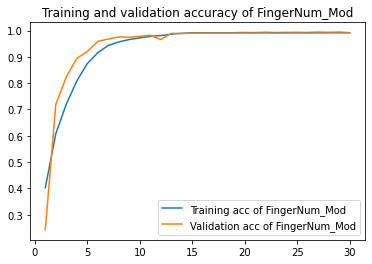

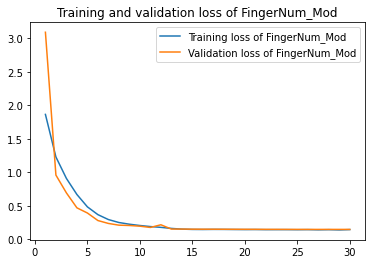

In [42]:
acc = [0] * nets
val_acc = [0] * nets
loss = [0] * nets
val_loss = [0] * nets
for i in range(nets):
    acc[i] = history[i].history['accuracy']
    val_acc[i] = history[i].history['val_accuracy']
    loss[i] = history[i].history['loss']
    val_loss[i] = history[i].history['val_loss']

    epochs = range(1, len(acc[i]) + 1)
    # plot figures models
    plt.figure()
    plt.plot(epochs, acc[i], label='Training acc of '+model_name[i])
    plt.plot(epochs, val_acc[i], label='Validation acc of '+model_name[i])
    plt.title('Training and validation accuracy of '+model_name[i])
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss[i],  label='Training loss of '+model_name[i])
    plt.plot(epochs, val_loss[i], label='Validation loss of '+model_name[i])
    plt.title('Training and validation loss of '+model_name[i])
    plt.legend()

#testing_acc_Id = model[0].evaluate([X_test], [y_SubjectID_test], verbose=0)
#print("Id recognition accuracy: ",testing_acc_Id[1]*100, "%")
testing_acc_finger = model[0].evaluate([X_test], [y_test], verbose=0)
print("Finger recognition accuracy: ",testing_acc_finger[1]*100, "%")

In [43]:
test_loss,test_acc = model[0].evaluate(X_test, y_test)
y_fingerNum_pred = model[0].predict(X_test)

63/63 [==============================] - 1s 13ms/step - loss: 1.9642 - accuracy: 0.6035


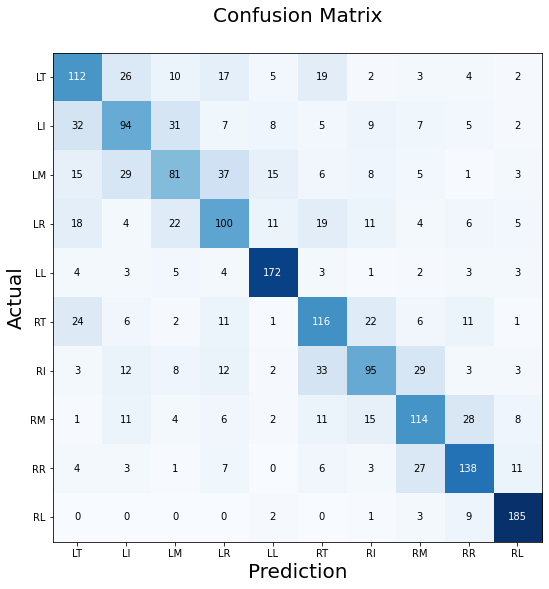

In [44]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

labels= ['LT', 'LI', 'LM', 'LR', 'LL', 'RT', 'RI', 'RM', 'RR', 'RL']
cf = confusion_matrix(y_test.argmax(axis = 1), y_fingerNum_pred.argmax(axis = 1))
fig, ax = plot_confusion_matrix(conf_mat=cf, figsize=(12, 9), cmap=plt.cm.Blues)
plt.xlabel('Prediction', fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.xticks([0,1,2,3,4,5,6,7,8,9],labels=labels,fontsize=10)
plt.yticks([0,1,2,3,4,5,6,7,8,9],labels=labels,fontsize=10)
plt.title('Confusion Matrix', fontsize=20)
plt.show()

In [45]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score
print(classification_report(y_test.argmax(axis = 1),y_fingerNum_pred.argmax(axis = 1)))

              precision    recall  f1-score   support

           0       0.53      0.56      0.54       200
           1       0.50      0.47      0.48       200
           2       0.49      0.41      0.45       200
           3       0.50      0.50      0.50       200
           4       0.79      0.86      0.82       200
           5       0.53      0.58      0.56       200
           6       0.57      0.47      0.52       200
           7       0.57      0.57      0.57       200
           8       0.66      0.69      0.68       200
           9       0.83      0.93      0.87       200

    accuracy                           0.60      2000
   macro avg       0.60      0.60      0.60      2000
weighted avg       0.60      0.60      0.60      2000



Resize

In [12]:
import cv2 as cv
samples  = X_fingerNum_train.shape[0]
X_train = np.empty((samples,96,96,3),dtype = "uint8")
for i in range(samples):
        img = np.array(X_fingerNum_train[i], dtype=np.uint8)
        grey = cv.resize(img,(96,96))
        X_train[i] = cv.cvtColor(grey,cv.COLOR_GRAY2BGR)

In [13]:
import cv2 as cv
samples  = X_fingerNum_val.shape[0]
X_val = np.empty((samples,96,96,3),dtype = "uint8")
for i in range(samples):
    img = np.array(X_fingerNum_val[i], dtype=np.uint8)
    grey = cv.resize(img,(96,96))
    X_val[i] = cv.cvtColor(grey,cv.COLOR_GRAY2BGR)

In [14]:
import cv2 as cv
samples  = X_test.shape[0]
X3_test = np.empty((samples,96,96,3),dtype = "uint8")
for i in range(samples):
    img = np.array(X_test[i], dtype=np.uint8)
    grey = cv.resize(img,(96,96))
    X3_test[i] = cv.cvtColor(grey,cv.COLOR_GRAY2BGR)

In [15]:
print("Shapes:                  Feature shape    label shape")
print("----------------------------------------------------")
print("fingerNum_Train:      ", np.shape(X_train), np.shape(y_fingerNum_train))
print("fingerNum_Validation: ", np.shape(X_val), np.shape(y_fingerNum_val))
print("fingerNum_Test:       ", np.shape(X3_test), np.shape(y_test))

Shapes:                  Feature shape    label shape
----------------------------------------------------
fingerNum_Train:       (26249, 96, 96, 3) (26249, 10)
fingerNum_Validation:  (6563, 96, 96, 3) (6563, 10)
fingerNum_Test:        (2000, 96, 96, 3) (2000, 10)


MobileNet

In [18]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model

base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(515,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
#x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(256,activation='relu')(x) #dense layer 3
preds=Dense(10,activation='softmax')(x) #final layer with softmax activation

In [19]:
MobilNet_model=Model(inputs=base_model.input,outputs=preds)

In [21]:
#CallBack = [
ReduceLR_minlr = [1e-9, 1e-7]
s = callbacks.EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1)
r = callbacks.ReduceLROnPlateau(factor=0.1, patience=1, min_lr=ReduceLR_minlr[0], verbose=1)
t = callbacks.TensorBoard(log_dir="./log_dir/"+"MobileNet_model")

In [22]:
MobilNet_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = MobilNet_model.fit(X_train, y_fingerNum_train, batch_size = 64, epochs = 30, validation_data = (X_val, y_fingerNum_val),callbacks= [s,r,t])

Epoch 1/30
411/411 [==============================] - 72s 139ms/step - loss: 1.0682 - accuracy: 0.6419 - val_loss: 1.6032 - val_accuracy: 0.4982 - lr: 1.0000e-04
Epoch 2/30
411/411 [==============================] - 56s 135ms/step - loss: 0.2228 - accuracy: 0.9365 - val_loss: 0.1879 - val_accuracy: 0.9426 - lr: 1.0000e-04
Epoch 3/30
411/411 [==============================] - 56s 136ms/step - loss: 0.0751 - accuracy: 0.9808 - val_loss: 0.1238 - val_accuracy: 0.9625 - lr: 1.0000e-04
Epoch 4/30
410/411 [============================>.] - ETA: 0s - loss: 0.0431 - accuracy: 0.9881
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
411/411 [==============================] - 55s 134ms/step - loss: 0.0436 - accuracy: 0.9880 - val_loss: 0.2346 - val_accuracy: 0.9256 - lr: 1.0000e-04
Epoch 5/30
411/411 [==============================] - 57s 139ms/step - loss: 0.0265 - accuracy: 0.9935 - val_loss: 0.0580 - val_accuracy: 0.9842 - lr: 1.0000e-05
Epoch 6/30
411/411 [=========

Finger recognition accuracy:  50.90000033378601 %


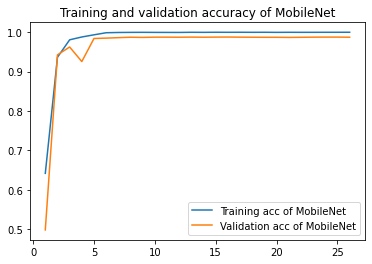

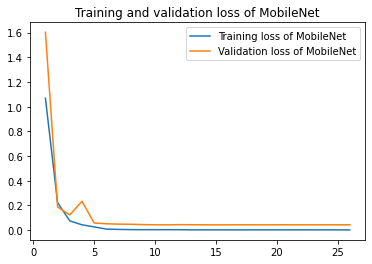

In [33]:
nets = 1
acc = [0] * nets
val_acc = [0] * nets
loss = [0] * nets
val_loss = [0] * nets
for i in range(nets):
    acc[i] = history.history['accuracy']
    val_acc[i] = history.history['val_accuracy']
    loss[i] = history.history['loss']
    val_loss[i] = history.history['val_loss']

    epochs = range(1, len(acc[i]) + 1)
    model_name= "MobileNet"
    # plot figures models
    plt.figure()
    plt.plot(epochs, acc[i], label='Training acc of '+model_name)
    plt.plot(epochs, val_acc[i], label='Validation acc of '+model_name)
    plt.title('Training and validation accuracy of '+model_name)
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss[i],  label='Training loss of '+model_name)
    plt.plot(epochs, val_loss[i], label='Validation loss of '+model_name)
    plt.title('Training and validation loss of '+model_name)
    plt.legend()

testing_acc_finger = MobilNet_model.evaluate([X3_test], [y_test], verbose=0)
print("Finger recognition accuracy: ",testing_acc_finger[1]*100, "%")

In [23]:
test_loss,test_acc = MobilNet_model.evaluate(X3_test, y_test)

63/63 [==============================] - 2s 23ms/step - loss: 2.7187 - accuracy: 0.5090


In [35]:
y_pred = MobilNet_model.predict(X3_test) # predicting from the test dataset

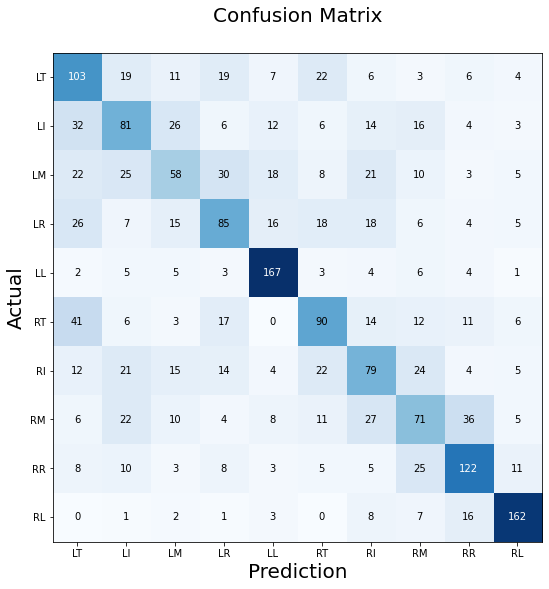

In [36]:
labels= ['LT', 'LI', 'LM', 'LR', 'LL', 'RT', 'RI', 'RM', 'RR', 'RL']
cf = confusion_matrix(y_test.argmax(axis = 1),y_pred.argmax(axis = 1))
fig, ax = plot_confusion_matrix(conf_mat=cf, figsize=(12, 9), cmap=plt.cm.Blues)
plt.xlabel('Prediction', fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.xticks([0,1,2,3,4,5,6,7,8,9],labels=labels,fontsize=10)
plt.yticks([0,1,2,3,4,5,6,7,8,9],labels=labels,fontsize=10)
plt.title('Confusion Matrix', fontsize=20)
plt.show()

Oops! Prediction is wrong!
Actual Label : left index
Predicted Label : right ring


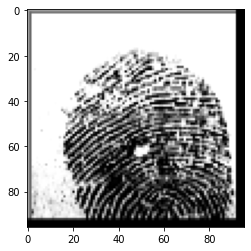

In [51]:
def show_fingername(fingernum):
    if fingernum>=5:
        fingername = "right "
        fingernum -= 5
    else: fingername = "left "
    if fingernum==0:
        fingername += "little"
    elif fingernum==1:
        fingername += "ring"
    elif fingernum==2:
        fingername += "middle"
    elif fingernum==3:
        fingername += "index"
    else: fingername += "thumb"
    return fingername

# Randomly pick a fingerprint from test data to predict both its Id and fingername
rand_fp_num = random.randint(0, X_test.shape[0]-1)
plt.imshow(X_test[rand_fp_num].reshape((96, 96)), cmap ='gray')
#y_SubjectID_pred = model[0].predict(X_test)
#Id_pred = np.argmax(y_SubjectID_pred[rand_fp_num])
#Id_real = np.argmax(y_SubjectID_test[rand_fp_num])
fingerNum_pred = np.argmax(y_fingerNum_pred[rand_fp_num])
fingerNum_real = np.argmax(y_test[rand_fp_num])
if fingerNum_pred==fingerNum_real:
    print("Infomation confirm! Fingerprint matches: person ", show_fingername(fingerNum_pred))
else:
    print("Oops! Prediction is wrong!")
    print("Actual Label :", show_fingername(fingerNum_real))
    print("Predicted Label :", show_fingername(fingerNum_pred))